# Create Motor Imagery Decoder
Use this clean notebook to create the decoder that will classify future motor imagery data. Please see `Exploration_Enobio_Motor_Screening.ipnyb` for the full exploration.

Nile Wilson 2019.01.16

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data

import scipy.signal as scisig
import numpy as np
import pandas as pd
import datetime
import pickle
import csv
import mne

## Function Definitions

In [23]:
def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

In [3]:
def LoadBehavioralData(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    behavioralData = behavioralData.transpose()
    behavioralHeader = behavioralData.iloc[0]
    behavioralData = behavioralData.iloc[2:]
    behavioralData.columns = behavioralHeader
    
    return behavioralData

In [4]:
def SyncTriggerPulses(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        # Store where the values in trigger are equal to 8 (the audio trigger input channel number)
        index_trigger = np.where(EEGdata['STI 014']!=0)
        index_trigger = index_trigger[0]
        
        # Check number of trials
        num_of_trials = behavioralData.shape[0]
        if num_of_trials > len(index_trigger):
            num_of_trials = num_of_trials - 1
            num_trials_removed = 1
        else:
            num_trials_removed = 0
        
        trialLength = int(behavioralData['trialLength'][0])

        # Get trial timing
        t_trial_start = list()
        t_trial_end = list()

        # Creating lists of all trigger start and end locations
        for i in range(0,num_of_trials):
            t_trial_start.append(index_trigger[i])
            t_trial_end.append(index_trigger[i] + int(trialLength*fs))

        # Save rest period epochs as well as trials for comparison
        t_rest_start = list()
        t_rest_end = list()

        for i in range(num_of_trials-1):
            t_rest_start.append(t_trial_end[i])
            t_rest_end.append(t_trial_start[i+1])
    
    return num_of_trials, t_trial_start, t_trial_end, t_rest_start, t_rest_end

In [5]:
def EpochData(EEGdata, t_trial_start, t_trial_end):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]
    
    epochs = []
    epochs_norm = []

    for trial in range(0,len(t_trial_start)):
        t_start = t_trial_start[trial]
        t_end = t_trial_end[trial]

        # Baseline
        if trial == 0:
            tb_start = t_trial_start[trial] - np.round(1.5*fs)
            tb_end = t_trial_start[trial]
        else:
            tb_start = t_trial_end[trial-1]
            tb_end = t_trial_start[trial]
            
        baseline = EEGdata.loc[tb_start:tb_end][channels]
        
        # Store epoch
        tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
        epochs_norm.append(tmp)
        epochs.append(EEGdata.loc[t_start:t_end][channels])
    
    return epochs, epochs_norm

In [6]:
def OrganizeTrials(behavioralData):
    """
    Organizes trials
    """
    
    # Create lists for each trial type
    trialL = list()
    trialR = list()
    i = 0

    for letter in behavioralData['trialType']:
        if letter == 'L':
            trialL.append(i)
        elif letter == 'R':
            trialR.append(i)
        i += 1
    
    # Create a single list that includes which trial is which (L = 0, R = 1)
    trial_type = list()
    i = 0

    for letter in behavioralData['trialType']:
        if letter == 'L':
            trial_type.append(0)
        elif letter == 'R':
            trial_type.append(1)
        i += 1

    return trial_type, trialL, trialR

In [7]:
def ExtractFeatures(epochs, num_of_trials, channelsToUse, ds_factor):
    """
    Extract signal features of interest
    """
    
    # Get the summed delta power for each trial
    alpha_power = dict.fromkeys(channelsToUse)
    beta_power = dict.fromkeys(channelsToUse)
    ds_f = ds_factor # downsampling factor

    for chanOfInt in channelsToUse:
        tmp_alpha = list()
        tmp_beta = list()

        for trial in range(0, num_of_trials):
            f, Pxx_den = signal.welch(signal.decimate(epochs[trial][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
            alpha_idx = np.where(np.logical_and(np.round(f) > 8, np.round(f) <= 12))
            tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))

            beta_idx = np.where(np.logical_and(np.round(f) > 13, np.round(f) <= 30))
            tmp_beta.append(np.sum(Pxx_den[beta_idx]))

        alpha_power[chanOfInt] = tmp_alpha
        beta_power[chanOfInt] = tmp_beta
    
    return alpha_power, beta_power

In [8]:
def TrainDecoder(X, y):
    """
    Trains the decoder on ALL the data (does not split into test and train because this is all train)
    """
    # preprocess dataset, split into training and test part
    args = np.arange(len(X))
    np.random.shuffle(args)
    X = [X[i] for i in args]
    y = [y[i] for i in args]
    X = StandardScaler().fit_transform(X)
    

    # Determine model parameters
    activations = ['relu','tanh']
    alphas = np.logspace(-6, 3, 10)
    solvers = ['lbfgs','sgd']
    hyper_params = {"activation":activations, "alpha":alphas, "solver":solvers}
    grid = GridSearchCV(MLPClassifier(learning_rate='constant', random_state=1), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)
    grid.fit(X, y)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X,y)
    
    """
    # Split into train and test for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    grid.fit(X_train, y_train)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    print(grid.best_estimator_)
    print('-----------')
    print('score: ' + str(score))
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('-----------')
    """
    
    return clf, X, y

In [9]:
def SaveDecoderAndData(clf, X, y, subjID):
    """
    Save the decoder and the data it was trained/tested on
    """
    time_to_save = datetime.datetime.now().isoformat()
    time_to_save = time_to_save.replace('T','-')
    time_to_save = time_to_save.replace(':','-')
    
    model = clf
    model_file = subjID + '_MI_classifier_' + time_to_save[:19] + '.sav'
    pickle.dump(model, open(model_file, 'wb'))
    
    filepath_export_data = subjID + '_data_for_MI_classifier_' + time_to_save[:19] + '.npz'
    np.savez_compressed(filepath_export_data, X=X, y=y)

## Variables to Set

In [10]:
subjID = 'nile'
EEGdevice = 8 # 7 for DSI-7, 8 for Enobio
filename_eeg = '../data/Enobio/20190124151108_nile_Motor_Screening.easy'
filename_behavioral = '../data/Enobio/nile_Motor_Screening_R1.csv.csv'

## Code to Run

### Run automatically

In [14]:
# Read in the .easy file
df = pd.read_csv(filename_eeg, delimiter='\t', header=None)

# Get metadata from the .info file
fname = filename_eeg[:-5] + '.info'
with open(fname) as f:
    content = f.readlines()
content = [x.strip() for x in content]

# Get the channel names
channel_info = [x for x in content if 'Channel ' in x]
channel_names = []
for ch in range(len(channel_info)):
    channel_names.append(channel_info[ch].split(': ')[1])

channel_names.append('X')
channel_names.append('Y')
channel_names.append('Z')
channel_names.append('STI 014')
channel_names.append('DateTime')

In [16]:
sampling_rates

['EEG sampling rate: 500 Samples/second',
 'Effective EEG sampling rate: N/A',
 'Accelerometer sampling rate: 100 Samples/second']

In [11]:
# Load EEG data
EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)

# Load behavioral data
behavioralData = LoadBehavioralData(filename_behavioral)

# Sync up trigger pulses
num_of_trials, t_trial_start, t_trial_end, t_rest_start, t_rest_end = SyncTriggerPulses(EEGdata, EEGdevice, fs, behavioralData)

ValueError: could not convert string to float: 'N/A'

### Run manually
Need to manually inspect and select ICs for artifact removal

Creating RawArray with float64 data, n_channels=7, n_times=300686
    Range : 0 ... 300685 =      0.000 ...   601.370 secs
Ready.
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 7 components
Fitting ICA took 1.8s.


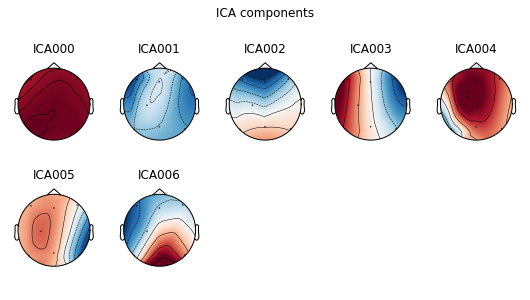

[<Figure size 540x288 with 10 Axes>]

In [12]:
# Clean the data
EEGdata_orig = EEGdata.copy()
lf = 1
hf = 40

if EEGdevice == 7:
    channels = EEGdata.columns[1:8]
elif EEGdevice == 8:
    channels = EEGdata.columns[0:8]

# Format our data into an mne-friendly format
ch_types = ['eeg']*len(channels)
info = mne.create_info(ch_names=list(channels), sfreq=fs, ch_types=ch_types)
rawData = EEGdata[channels].values
rawData = np.transpose(rawData)
raw = mne.io.array.RawArray(rawData, info)
raw.set_montage(mne.channels.read_montage(kind='standard_1020'))
raw.filter(l_freq=lf, h_freq=hf)

# Run ICA
n_components = 7
method = 'fastica'
random_state = 23
ica = mne.preprocessing.ICA(n_components=n_components, method=method, random_state=random_state)
reject = dict(mag=5e-12, grad=4000e-13)
ica.fit(raw, reject=reject)

%matplotlib inline
ica.plot_components()

<IPython.core.display.Javascript object>


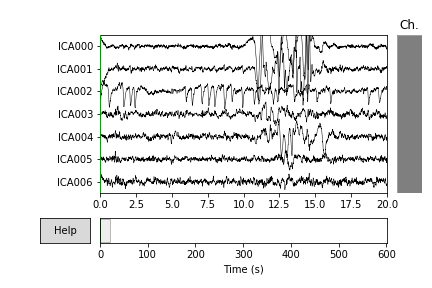

<IPython.core.display.Javascript object>


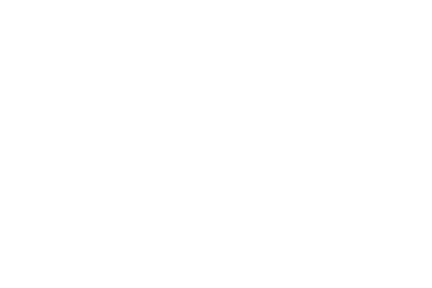

In [13]:
%matplotlib notebook
fig = ica.plot_sources(raw)

    using multitaper spectrum estimation with 7 DPSS windows


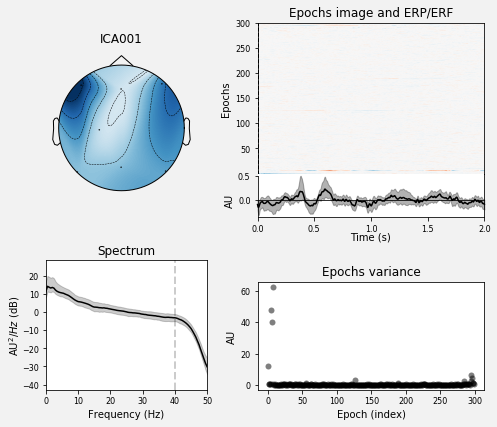

[<Figure size 504x432 with 5 Axes>]

In [14]:
# Take a closer look at an individual component
%matplotlib inline
ica.plot_properties(raw, picks=[1])

Decide which IC(s) to exclude by editing the first line in the cell below

In [15]:
ica.exclude = [] # most likely to be blinks (when you check source you can see clearly)
raw_corrected = raw.copy()
ica.apply(raw_corrected)

# Make a copy of the original data just in case
EEGdata[channels] = raw_corrected.get_data().T

Transforming to ICA space (7 components)
Zeroing out 0 ICA components


### Run automatically

In [16]:
# Epoch the data
epochs, epochs_norm = EpochData(EEGdata, t_trial_start, t_trial_end)

# Organize trial types
trial_type, trialL, trialR = OrganizeTrials(behavioralData)

# Get signal features
alpha_power, beta_power = ExtractFeatures(epochs_norm, num_of_trials, ['C3','C4'], 1)
motor_features = [alpha_power['C3'], alpha_power['C4'], beta_power['C3'], beta_power['C4']]
motor_features = np.transpose(motor_features)

# Train model
clf, X, y = TrainDecoder(motor_features, trial_type)

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: Convergen

In [17]:
# Save decoder and data it was trained/tested on
SaveDecoderAndData(clf, X, y, subjID)